In [1]:
import torch
import torch.nn as nn
# reused from HW
# Note that while the architecture is the same as the one used for the homework, I did try other architectures to no avail
# Adding layers didn't improve performance substantially, nor did decreasing the number of nodes. 
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.weights = nn.Sequential(nn.Linear(15,256), 
                                     nn.ReLU(), 
                                     nn.Linear(256, 128), 
                                     nn.ReLU(),
                                     nn.Linear(128, 6)
                                    )

    def forward(self, x):
        return self.weights(x)

In [ ]:
from random import sample
from collections import deque
import copy
import numpy as np
# reused this cell from HW, then made modifications to make it fit the mancala environment
# Check for GPU availability (CUDA first, then MPS, then CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

class MancalaAgent:
    """
    Implements a deep Q-learning agent for the Mancala environment.
    """
    def __init__(self, env, discount=0.99, learning_rate=0.001,
                 buffer_size=100000, batch_size=256, target_update_freq=20000,
                 epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.9999):
        """
        Initialize the DQN agent.
        
        Args:
            discount: Discount factor (gamma)
            learning_rate: Learning rate for optimizer
            buffer_size: Maximum size of replay buffer
            batch_size: Number of transitions to sample per update
            target_update_freq: Steps between target network updates
            epsilon_start: Initial exploration rate
            epsilon_min: Minimum exploration rate
            epsilon_decay: Multiplicative decay for epsilon
        """
        self.env = env
        self.discount = discount
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Initialize replay buffer
        self.replay_buffer = deque(maxlen=buffer_size)
        
        self.network = NeuralNet().to(device)
        self.saved_network = NeuralNet().to(device)
        self.loss = nn.MSELoss()
        self.opt = torch.optim.Adam(self.network.parameters(), lr = learning_rate)
        self.steps = 0
    @torch.no_grad()
    def action_select(self, state):
        """
        Epsilon-greedy action selection using neural network.
        
        Args:
            state: array of shape (15,)
            
        Returns:
            action: Integer action (0-5)
        """
        # filter to make sure not making illegal moves
        if state[-1] == 1:
            legal_actions = [i for i in range(6) if state[i] > 0]
        else: 
            legal_actions = [i for i in range(6) if state[i+7] > 0]
        
        if len(legal_actions) == 0:
            return self.env.action_space.sample()
        # random action selection
        if np.random.rand() < self.epsilon:
            return np.random.choice(legal_actions)

        # make a choice based on the q-values
        else:
            q_values = self.network(torch.tensor(state, dtype=torch.float).to(device)).cpu().numpy()
            
            masked_q_values = np.full(6, -np.inf)
            masked_q_values[legal_actions] = q_values[legal_actions]
            
            return np.argmax(masked_q_values)



    def update(self, state, action, reward, next_state, terminated):
        """
        Store experience and perform learning update if buffer is ready.
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            terminated: Whether episode terminated
        """
        self.replay_buffer.append((state, action, reward, next_state, terminated))
        self.steps += 1
        if len(self.replay_buffer) < self.batch_size:
            return
        
        self.network.train()  # Ensure network is in training mode
        
        batch = sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.tensor(np.array(states), dtype=torch.float).to(device)
        actions = torch.tensor(np.array(actions), dtype=torch.long).unsqueeze(1).to(device)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float).unsqueeze(1).to(device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float).to(device)
        terminations = torch.tensor(np.array(dones), dtype=torch.float).unsqueeze(1).to(device)
        
        with torch.no_grad():
            next_q_values = self.saved_network(next_states).max(1)[0].reshape(-1, 1)
            targets = (rewards + (1 - terminations) * self.discount * next_q_values).clone().detach()
        
        current_q_values = self.network(states)
        predictions = current_q_values.gather(1, actions)
        l = self.loss(predictions, targets)
        l.backward()
        self.opt.step()
        self.opt.zero_grad()
        if self.steps > self.target_update_freq:
            self.saved_network.load_state_dict(self.network.state_dict())
            self.steps = 0
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

Using device: cuda


In [3]:
import gymnasium as gym
# hit tab a lot when writing this class in Cursor
# used desmos to figure out how sides aligned 
class MancalaEnv(gym.Env):

    # boilerplate code for setting up environment
    # use a single array to track all information about the game state
    def __init__(self):
        self.state = [0]*15
        self.observation_space = gym.spaces.Box(low=0, high=48, shape=(15,), dtype=int)
        self.state[-1] = 1
        self.action_space = gym.spaces.Discrete(6)
        for i in range(6):
            self.state[i] = 4
            self.state[7 + i] = 4

    # print game state in a format that maps to meanings 
    def _get_info(self):
        return {
            "is_player_1_turn": self.state[14],
            "p1_score": self.state[6],
            "p1_pieces": self.state[0:6],
            "p2_score": self.state[13],
            "p2_pieces": self.state[7:13]
        }

    # reset the game state and put stones in the starting positions
    def reset(self, seed = None, options = None):
        super().reset(seed = seed, options = options)
        self.state = [0]*15
        self.state[-1] = 1
        for i in range(6):
            self.state[i] = 4
            self.state[7 + i] = 4
        return self.state, self._get_info()
    
    # take an aciton and update the game state accordingly
    def step(self, action):
        # change turn
        isTerminated = False
        self.state[14] = 1 - self.state[14]

        # if it's player 2's turn, call the p2 step function
        if self.state[14] == 1: 
            return self._step_adversarial(action)
        
        reward = 0
        # if the action is illegal, return a penalty and reset the turn
        if action < 0 or action > 5 or self.state[action] == 0:
            self.state[14] = 1 - self.state[14]
            return self.state, -10, isTerminated, False, self._get_info()
        # set the number of stones to 0 in the chosen pit, then put the stones in the following pits
        stones = self.state[action]
        self.state[action] = 0
        i = action + 1
        for _ in range(stones):
            self.state[i] += 1
            # if the stone is in the store, index reward by 1
            if i == 6: 
                reward += 1
            i += 1
            # if looped around, reset index to 0, skipping the opponent's store
            if i >= 13:
                i = 0
        i -= 1
        # if the last stone was put into the player's store, change the turn back to that player
        if i == 6:
            self.state[14] = 1 - self.state[14]
        # if the last stone was put into a pit with an opponent's stone on the other side, capture the stones into the store. 
        if self.state[12 - i] > 0 and self.state[i] == 1 and i < 6:
            reward += self.state[12 - i] + self.state[i]
            self.state[12 - i] = 0
            self.state[i] = 0
        # if one of the players have no stones left, add the remaining stones on the other side to that player's store and end the game
        # we don't give a reward for having pieices left at the end to add, otherwise the agent tries to optimize too much for having pieces remaining instead of winning. 
        if sum(self.state[0:6]) == 0 or sum(self.state[7:13]) == 0:
            isTerminated = True
            self.state[6] += sum(self.state[0:6])
            self.state[13] += sum(self.state[7:13])
            if self.state[6] > self.state[13]:
                reward += 50 
            elif self.state[13] > self.state[6]:
                reward -= 50  
            # no reward for a tie
        return self.state, reward, isTerminated, False, self._get_info()
    
    # player 2 logic, same as player 1, just with different indices
    # used negative reward for the opponent's moves, because mancala is a zero-sum game, and in training the agent will always be p1. 
    def _step_adversarial(self, action):
        isTerminated = False
        # index the action by 7 to get the correct index for the opppoent's pieces
        action = action + 7
        reward = 0
        if action < 7 or action > 12 or self.state[action] == 0:
            return self.state, -10, isTerminated, False, self._get_info()
        stones = self.state[action]
        self.state[action] = 0
        i = action + 1
        for _ in range(stones):
            self.state[i] += 1
            if i == 13: 
                reward -= 1
            i += 1
            if i >= 14:
                i = 0
        if i == 0:
            self.state[14] = 1 - self.state[14]
        else: 
            i -= 1
            if self.state[i] == 1 and self.state[12 - i] > 0 and i > 6:
                captured = self.state[12 - i] + self.state[i]
                reward -= captured
                self.state[12 - i] = 0
                self.state[i] = 0
        if sum(self.state[0:6]) == 0 or sum(self.state[7:13]) == 0:
            isTerminated = True
            self.state[6] += sum(self.state[0:6])
            self.state[13] += sum(self.state[7:13])
            if self.state[6] > self.state[13]:
                reward += 50 
            elif self.state[13] > self.state[6]:
                reward -= 50
        return self.state, reward, isTerminated, False, self._get_info()



In [4]:
# boilerplate code for setting up the environment, was used from the gymnasium documentation. 
gym.register(
    id="gymnasium_env/mancala_env-v0",
    entry_point=MancalaEnv,
    max_episode_steps=200
)

In [5]:
from copy import deepcopy
import matplotlib.pyplot as plt
# hit tab some when writing this function in Cursor (inculding this comment)
def self_play(agent, env, n_episodes=1000, print_every=10, agent_pool_size=20, use_current_ratio=0.3, update_every=200):
    tot_return = 0
    tot_length = 0
    count = 0
    # copied the idea for this from the huggingface tutorial about self-play, but didn't directly use the code
    # pool of past agents to randomly pick from as an adversary
    agent_index = 0
    agent_pool = [deepcopy(agent) for _ in range(agent_pool_size)]
    randomWinrates = []
    for episode in range(n_episodes):
        state, info = env.reset()
        episode_over = False
        # each episode, randomly choose if the oppoenent will be the current agent or a past one chosen at random
        if np.random.rand() > use_current_ratio:
            opponent_agent = np.random.choice(agent_pool)
        else:
            opponent_agent = agent
        # randomly pick if going first, if not then have opponent pick action
        # prevents the agent from only learning how to play when going first
        if np.random.rand() < .5:
            while state[-1] == 1:
                outcome = env.step(opponent_agent.action_select(state))
                state = outcome[0]
            for i in range(7):
                temp = state[i]
                state[i] = state[7+i]
                state[i+7] = temp
            state[-1] = 1
            env.state = state
        while not episode_over:
            action = agent.action_select(state)
            outcome = env.step(action)
            reward = outcome[1]
            tot_return += outcome[1]
            episode_over = outcome[2] or outcome[3]
            action_saved = action
            state_saved = state
            state = outcome[0]
            # if it's p1's turn again, this is skipped
            # if p2's turn repeats due to the stones ending in their store, this loops until their turn ends on a non-store pit. 
            while state[-1] == 0 and not episode_over:
                # flipping the board so that the opponent's side is in the correct position for prediction. 
                temp_state = state.copy()
                for i in range(7):
                    temp_state[i] = state[7+i]
                    temp_state[i+7] = state[i]
                action = opponent_agent.action_select(temp_state)
                outcome = env.step(action)
                episode_over = outcome[2] or outcome[3]
                reward += outcome[1]
                state = outcome[0]
                tot_length += 1
            agent.update(state_saved, action_saved, reward, outcome[0], outcome[2])
            tot_length += 1
        # update the pool of agents for adversarial selection
        if episode % update_every == 0:
            agent_pool[agent_index] = deepcopy(agent)
            agent_pool[agent_index].epsilon = 0
            agent_index = (agent_index + 1) % agent_pool_size
        # print current success rates and training info
        if print_every and (episode + 1) % print_every == 0:
            print("="*50)
            print(f"{round(100*(episode+1)/n_episodes)}% done training")
            print(f"True reward: {tot_return/print_every}")
            print(f"Episode length: {tot_length/print_every}")
            print(f"Agent epsilon: {agent.epsilon}")
            random_winrate = play_random(agent, env, n_episodes=50)
            randomWinrates.append(random_winrate)
            print(f"Winrate against random agent: {random_winrate}")
            play_random(agent, env, n_episodes=50)
            tot_return = 0
            tot_length = 0
     
    # this line + plotting code generated by Cursor
    percent_complete = np.arange(print_every, n_episodes + 1, print_every) / n_episodes * 100

    plt.figure(figsize=(12, 6))
    plt.plot(percent_complete, randomWinrates, marker='o', linewidth=2, markersize=4)
    plt.xlabel('Training Progress (%)', fontsize=12)
    plt.ylabel('Win Rate Against Random Agent', fontsize=12)
    plt.title('Agent Performance vs Random Opponent During Training', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.xlim(0, 100)

    plt.tight_layout()
    plt.show()
    return agent, env

In [6]:
import time
# similar to self-play function, just plays a agent that randomly selects a legal action
# a well-trained agent should be able to consistently beat this agent. 
def play_random(agent, env, n_episodes=1000, print_every=10):
    tot_return = 0
    tot_length = 0
    wins = 0
    count = 0
    for episode in range(n_episodes):
        state, info = env.reset()
        episode_over = False
        if np.random.rand() < .5:
            outcome = env.step(np.random.randint(0, 6))
            state = outcome[0]
            for i in range(7):
                temp = state[i]
                state[i] = state[7+i]
                state[i+7] = temp
        while not episode_over:
            action = agent.action_select(state)
            outcome = env.step(action)
            if outcome[1] >= 25:
                wins += 1
            tot_return += outcome[1]
            episode_over = outcome[2] or outcome[3]
            state = outcome[0]
            while state[-1] == 0 and not episode_over:
                legal_moves = [i for i in range(6) if state[i+7] > 0]
                if len(legal_moves) > 0:
                    action = np.random.choice([i for i in range(6) if state[i+7] > 0])
                else: 
                    action = np.random.randint(0, 6)
                outcome = env.step(action)
                episode_over = outcome[2] or outcome[3]
                state = outcome[0]
                if outcome[1] >= 25:
                    wins += 1
                tot_length += 1
            tot_length += 1
    return wins/n_episodes

/home/users/jsc123/.local/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:130: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(
/home/users/jsc123/.local/lib/python3.11/site-packages/gymnasium/spaces/box.py:424: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/home/users/jsc123/.local/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:130: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(


2% done training
True reward: 25.7
Episode length: 48.71
Agent epsilon: 0.7933335120023546
Winrate against random agent: 0.6
4% done training
True reward: 24.61
Episode length: 49.32
Agent epsilon: 0.6106540631082263
Winrate against random agent: 0.64
6% done training
True reward: 36.58
Episode length: 48.22
Agent epsilon: 0.46947613724232456
Winrate against random agent: 0.74
8% done training
True reward: 35.14
Episode length: 46.62
Agent epsilon: 0.36231156396615544
Winrate against random agent: 0.64
10% done training
True reward: 27.84
Episode length: 47.82
Agent epsilon: 0.27910595303930164
Winrate against random agent: 0.64
12% done training
True reward: 30.54
Episode length: 46.8
Agent epsilon: 0.2152453367785995
Winrate against random agent: 0.72
14% done training
True reward: 24.34
Episode length: 45.25
Agent epsilon: 0.16808437963376935
Winrate against random agent: 0.8
16% done training
True reward: 30.4
Episode length: 42.18
Agent epsilon: 0.13313377599537843
Winrate against

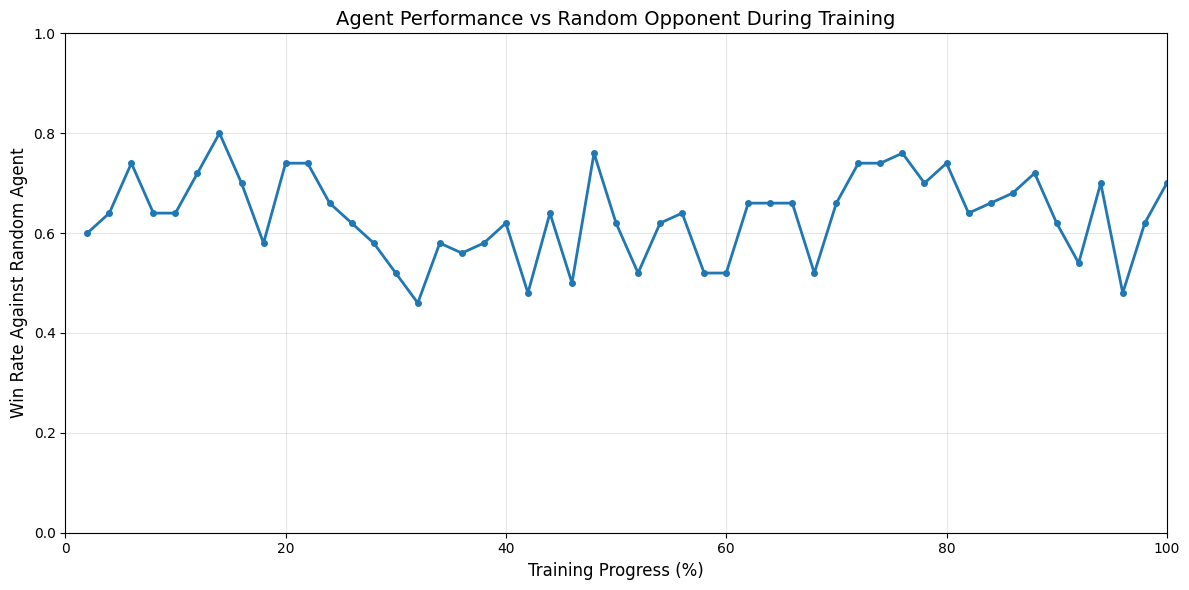

True winrate against random agent for deepq_agent_short: 0.637
1% done training
True reward: 27.684
Episode length: 51.368
Agent epsilon: 0.5218200292137358
Winrate against random agent: 0.54
2% done training
True reward: 26.892
Episode length: 51.48
Agent epsilon: 0.2632458916259857
Winrate against random agent: 0.54
3% done training
True reward: 22.368
Episode length: 51.548
Agent epsilon: 0.13282790490338028
Winrate against random agent: 0.34
4% done training
True reward: 24.332
Episode length: 53.94
Agent epsilon: 0.06541940518981378
Winrate against random agent: 0.52
5% done training
True reward: 27.816
Episode length: 50.376
Agent epsilon: 0.05
Winrate against random agent: 0.38
6% done training
True reward: 23.968
Episode length: 50.66
Agent epsilon: 0.05
Winrate against random agent: 0.4
7% done training
True reward: 22.508
Episode length: 50.948
Agent epsilon: 0.05
Winrate against random agent: 0.54
8% done training
True reward: 23.408
Episode length: 48.848
Agent epsilon: 0.0

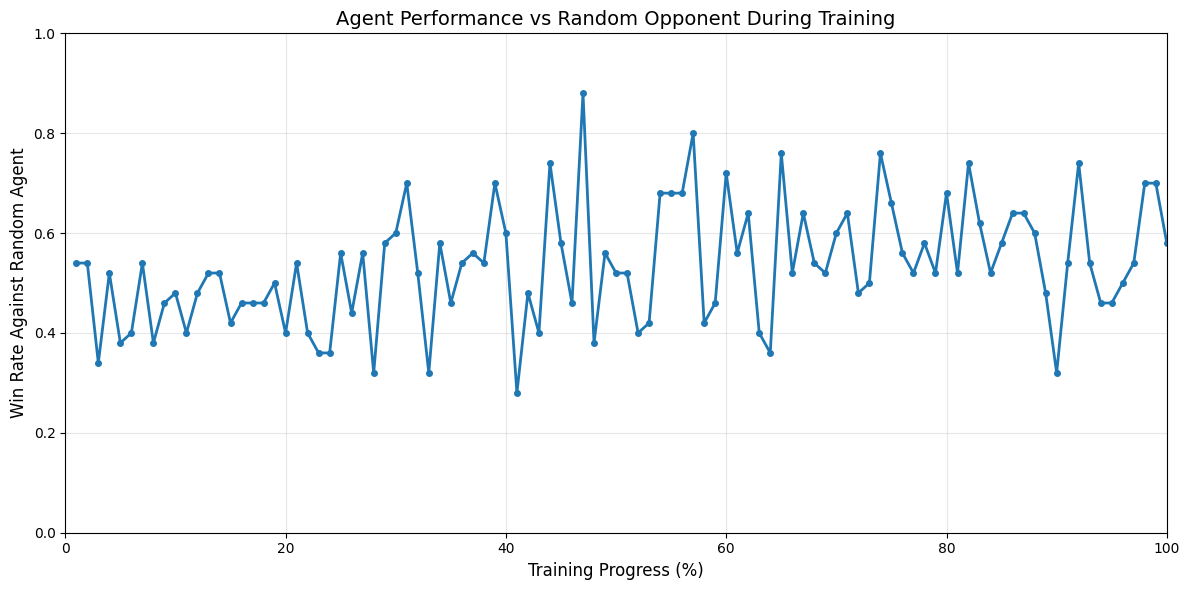

True winrate against random agent for deepq_agent_medium: 0.686
1% done training
True reward: 22.9
Episode length: 50.886
Agent epsilon: 0.2703695912966012
Winrate against random agent: 0.56
2% done training
True reward: 35.08
Episode length: 48.12
Agent epsilon: 0.07163784316717295
Winrate against random agent: 0.66
3% done training
True reward: 37.678
Episode length: 45.176
Agent epsilon: 0.05
Winrate against random agent: 0.58
4% done training
True reward: 21.846
Episode length: 43.794
Agent epsilon: 0.05
Winrate against random agent: 0.68
5% done training
True reward: 30.924
Episode length: 46.212
Agent epsilon: 0.05
Winrate against random agent: 0.52
6% done training
True reward: 33.55
Episode length: 47.302
Agent epsilon: 0.05
Winrate against random agent: 0.52
7% done training
True reward: 27.402
Episode length: 44.582
Agent epsilon: 0.05
Winrate against random agent: 0.6
8% done training
True reward: 13.87
Episode length: 46.194
Agent epsilon: 0.05
Winrate against random agent:

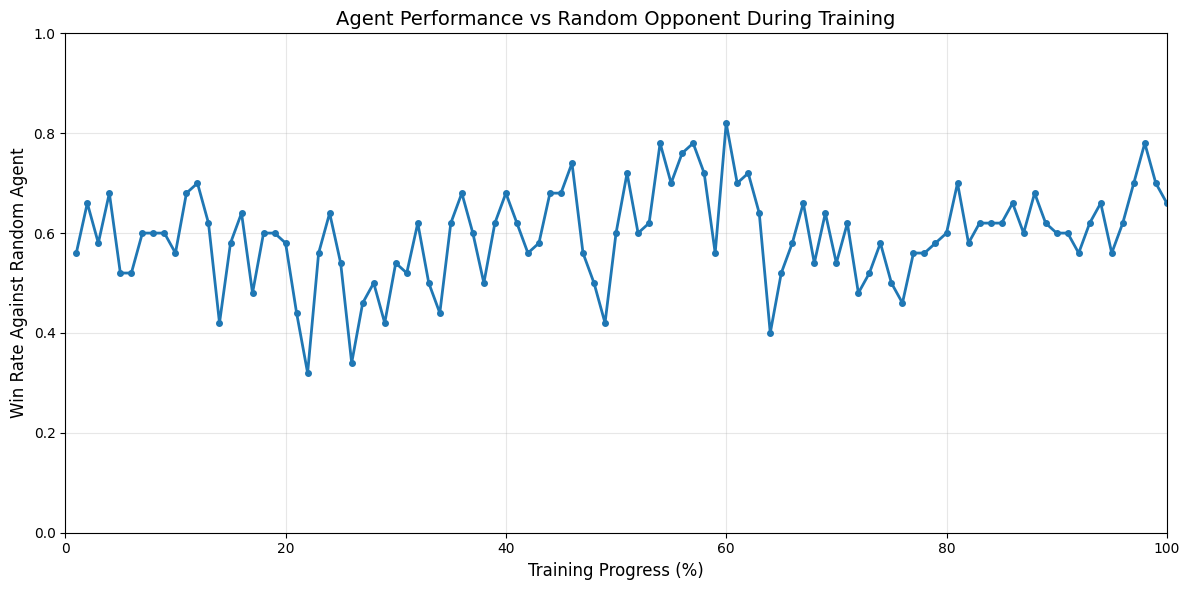

True winrate against random agent for deepq_agent_long: 0.693

Training complete!


In [7]:
# TRAINING CODE, DO NOT RUN UNLESS CREATING NEW MODEL
import gymnasium as gym
import numpy as np

np.random.seed(42)

n_episodes = [5000, 25000, 50000]
titles = ["deepq_agent_short", "deepq_agent_medium", "deepq_agent_long"]
update_freq = [100, 250, 500]

env = gym.make("gymnasium_env/mancala_env-v0")

for i in range(3):
    # Can adjust training hyperparameters of agent as needed
    agent = MancalaAgent(env, target_update_freq=1000, epsilon_min=.05, learning_rate=.001)
    # Train the agent
    agent, env = self_play(agent, env, n_episodes=n_episodes[i], print_every=update_freq[i], agent_pool_size=10, use_current_ratio=0.5, update_every=update_freq[i])
    print(f"True winrate against random agent for {titles[i]}: {play_random(agent, env, n_episodes=1000)}")
    torch.save(agent.network.state_dict(), titles[i] + '.pth')
print(f"\nTraining complete!")

In [ ]:
# Used cursor when writing this class, mainly via a lot of tabbing

class ReinforceAgent:
    """
    Implements a policy-learning agent for the Mancala environment.
    
    """
    def __init__(self, env, discount=0.99, learning_rate=0.00001):
        """
        Initialize the agent.
        
        Args:
            discount: Discount factor (gamma)
            learning_rate: Learning rate for optimizer
        """
        self.env = env
        self.discount = discount
        
        
        self.network = NeuralNet().to(device)
        self.saved_network = NeuralNet().to(device)
        self.opt = torch.optim.Adam(self.network.parameters(), lr = learning_rate)
    # had a first draft, cursor regenrated this in the course of debugging. 
    @torch.no_grad()
    def action_select(self, state):
        """
            selection of an aciton based on the state and policy 
        """
        probs = self.network(torch.tensor(state, dtype=torch.float).to(device))
        # Mask illegal actions
        if state[-1] == 1:
            legal_actions = [i for i in range(6) if state[i] > 0]
        else:
            legal_actions = [i for i in range(6) if state[i+7] > 0]

        if len(legal_actions) == 0:
            return self.env.action_space.sample()
        
        for i in range(6):
            if i not in legal_actions:
                probs[i] = -1e9

        probs = torch.softmax(probs, dim=0).cpu().numpy()
        return np.random.choice(6, p=probs)

    # autogenerate by cursor
    def compute_returns(self, rewards):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.discount * R
            returns.append(R)
        return list(reversed(returns))  # Reverse to match original order

    # reused from the previous agent, modified it to work with policy learning 
    def update(self, states, actions, action_mask, returns):
        """
        Store experience and perform learning update if buffer is ready.
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            terminated: Whether episode terminated
        """
        
        self.network.train()  # Ensure network is in training mode
        
        # Convert to tensors with correct shapes
        states_tensor = torch.tensor(np.array(states), dtype=torch.float).to(device)
        actions_tensor = torch.tensor(np.array(actions), dtype=torch.long).to(device)
        returns_tensor = torch.tensor(np.array(returns), dtype=torch.float).to(device)
        action_mask_tensor = torch.tensor(np.array(action_mask), dtype=torch.float).to(device)
        
        # this logic largely implemented by cursor, I wasn't sure about how to convert the mathematical formulas into code and used cursor to help. 
        # Get logits from network
        logits = self.network(states_tensor)
        
        # Apply action mask (illegal actions have -1e9, legal actions have 0)
        masked_logits = logits + action_mask_tensor
        
        # Apply softmax to get probabilities
        probs = torch.softmax(masked_logits, dim=1)
        
        # Get log probabilities for the taken actions
        log_probs = torch.log(probs + 1e-8)  # Add small epsilon for numerical stability
        selected_log_probs = log_probs.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
        

        loss = -(selected_log_probs * returns_tensor).mean()
        
        # Backpropagate
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

In [9]:
# similar to the self-play funciton, just made some minor tweaks to make it work for policy learning
def reinforce_self_play(agent, env, n_episodes=1000, print_every=10, agent_pool_size=5, use_current_ratio=0.5, update_every=100):
    tot_return = 0
    tot_length = 0
    count = 0

    agent_pool = [deepcopy(agent) for _ in range(agent_pool_size)]
    agent_index = 0
    randomWinrates = []
    for episode in range(n_episodes):
        # use a queue of actions for a particular episode, then train off of all actions for that episode. 
        action_queue = []
        state_queue = []
        reward_queue = []
        action_mask_queue = []
        state, info = env.reset()
        episode_over = False
        if np.random.rand() < use_current_ratio:
            opponent_agent = np.random.choice(agent_pool)
        else:
            opponent_agent = agent
        #randomly pick if going first, if not then have opponent pick action
        if np.random.rand() < .5:
            while state[-1] == 1:
                outcome = env.step(opponent_agent.action_select(state))
                state = outcome[0]
            for i in range(7):
                temp = state[i]
                state[i] = state[7+i]
                state[i+7] = temp
            state[-1] = 1
            env.state = state
        while not episode_over:
            action = agent.action_select(state)
            legal_actions = [-1e9 if state[i] == 0 else 0 for i in range(6)]
            outcome = env.step(action)
            reward = outcome[1]
            tot_return += outcome[1]
            episode_over = outcome[2] or outcome[3]
            action_queue.append(action)
            state_queue.append(state)
            # need a mask for illegal actions when doing backprop. 
            action_mask_queue.append(legal_actions)
            state = outcome[0]
            while state[-1] == 0 and not episode_over:
                temp_state = state.copy()
                for i in range(7):
                    temp_state[i] = state[7+i]
                    temp_state[i+7] = state[i]
                action = opponent_agent.action_select(temp_state)
                outcome = env.step(action)
                episode_over = outcome[2] or outcome[3]
                reward += outcome[1]
                state = outcome[0]
                tot_length += 1
            reward_queue.append(reward)
            tot_length += 1
        returns = agent.compute_returns(reward_queue)
        agent.update(state_queue, action_queue, action_mask_queue, returns)
        if episode % update_every == 0:
            agent_pool[agent_index] = deepcopy(agent)
            agent_index = (agent_index + 1) % agent_pool_size
        if print_every and (episode + 1) % print_every == 0:
            print("="*50)
            print(f"{round(100*(episode+1)/n_episodes)}% done training")
            print(f"True reward: {tot_return/print_every}")
            print(f"Episode length: {tot_length/print_every}")
            random_winrate = play_random(agent, env, n_episodes=50)
            randomWinrates.append(random_winrate)
            print(f"Winrate against random agent: {random_winrate}")
            tot_return = 0
            tot_length = 0
    # this line + plotting code generated by Cursor
    percent_complete = np.arange(print_every, n_episodes + 1, print_every) / n_episodes * 100

    plt.figure(figsize=(12, 6))
    plt.plot(percent_complete, randomWinrates, marker='o', linewidth=2, markersize=4)
    plt.xlabel('Training Progress (%)', fontsize=12)
    plt.ylabel('Win Rate Against Random Agent', fontsize=12)
    plt.title('Agent Performance vs Random Opponent During Training', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.xlim(0, 100)

    plt.tight_layout()
    plt.show()
    return agent, env

10% done training
True reward: 12.35
Episode length: 62.15
Winrate against random agent: 0.58
20% done training
True reward: 40.1
Episode length: 59.46
Winrate against random agent: 0.48
30% done training
True reward: 45.46
Episode length: 60.34
Winrate against random agent: 0.52
40% done training
True reward: 43.37
Episode length: 59.05
Winrate against random agent: 0.66
50% done training
True reward: 49.56
Episode length: 59.92
Winrate against random agent: 0.62
60% done training
True reward: 45.88
Episode length: 62.51
Winrate against random agent: 0.46
70% done training
True reward: 53.1
Episode length: 63.18
Winrate against random agent: 0.56
80% done training
True reward: 56.88
Episode length: 59.79
Winrate against random agent: 0.56
90% done training
True reward: 55.77
Episode length: 60.95
Winrate against random agent: 0.64
100% done training
True reward: 48.96
Episode length: 64.16
Winrate against random agent: 0.56


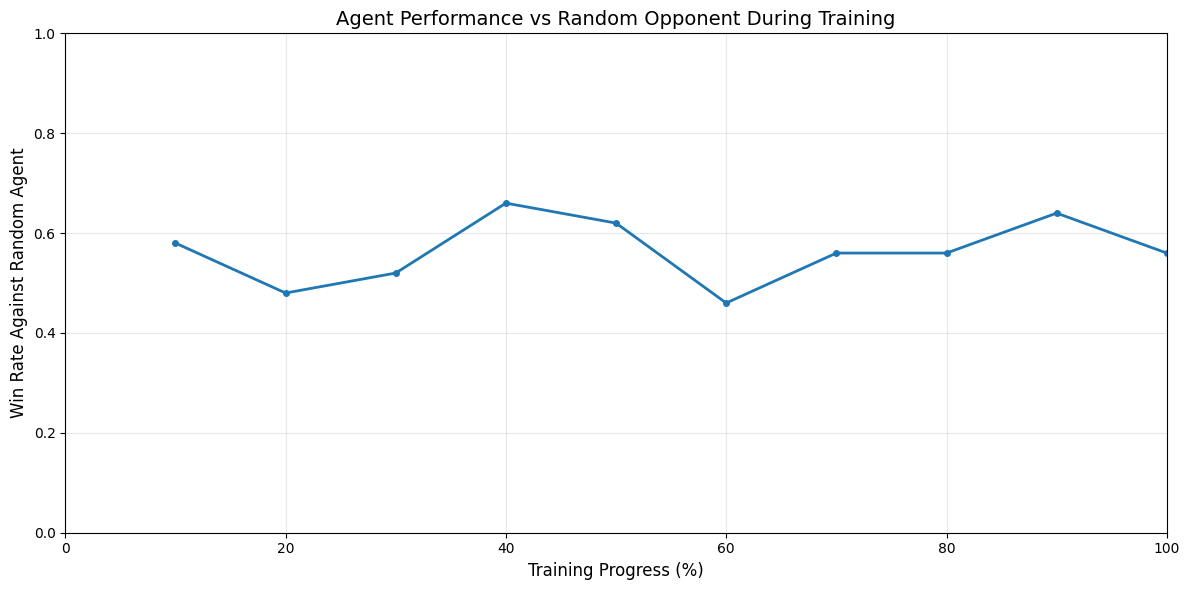

True winrate against random agent: 0.531
2% done training
True reward: 32.856
Episode length: 48.88
Winrate against random agent: 0.44
5% done training
True reward: 41.76
Episode length: 50.596
Winrate against random agent: 0.6
8% done training
True reward: 39.744
Episode length: 49.364
Winrate against random agent: 0.68
10% done training
True reward: 39.444
Episode length: 48.912
Winrate against random agent: 0.42
12% done training
True reward: 37.132
Episode length: 49.528
Winrate against random agent: 0.52
15% done training
True reward: 24.628
Episode length: 43.192
Winrate against random agent: 0.4
18% done training
True reward: -24.784
Episode length: 24.04
Winrate against random agent: 0.54
20% done training
True reward: -24.696
Episode length: 24.144
Winrate against random agent: 0.48
22% done training
True reward: -27.556
Episode length: 23.224
Winrate against random agent: 0.56
25% done training
True reward: -30.216
Episode length: 21.432
Winrate against random agent: 0.52
28%

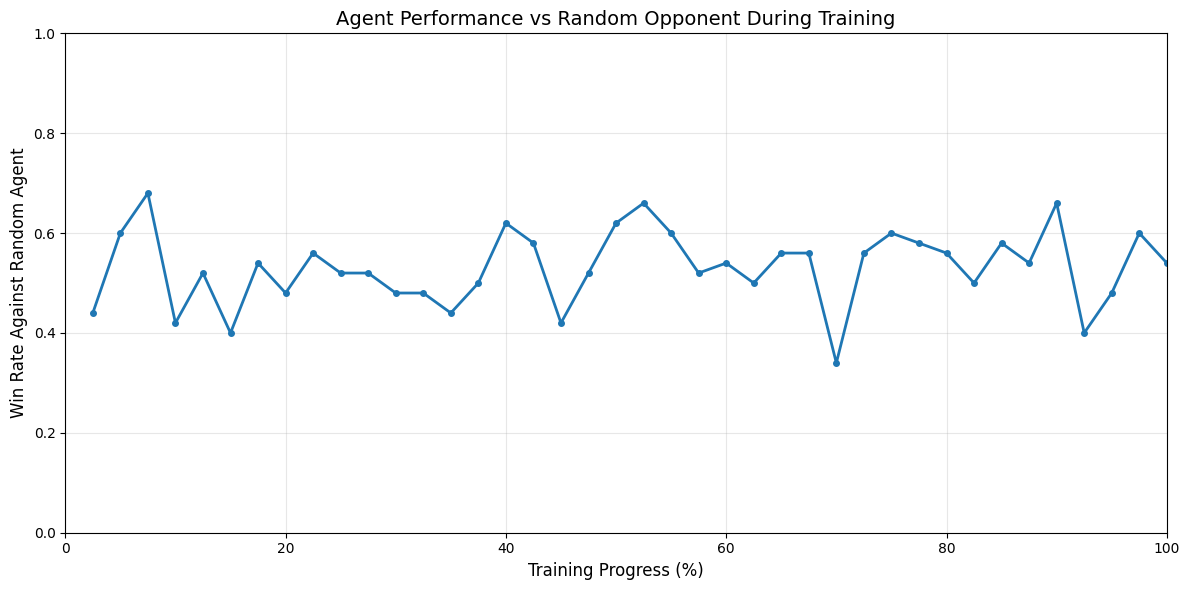

True winrate against random agent: 0.527
0% done training
True reward: -6.69
Episode length: 57.398
Winrate against random agent: 0.56
1% done training
True reward: -7.99
Episode length: 57.162
Winrate against random agent: 0.58
2% done training
True reward: -17.206
Episode length: 67.998
Winrate against random agent: 0.7
2% done training
True reward: -20.156
Episode length: 68.45
Winrate against random agent: 0.74
2% done training
True reward: -20.74
Episode length: 68.868
Winrate against random agent: 0.66
3% done training
True reward: -21.022
Episode length: 69.934
Winrate against random agent: 0.74
4% done training
True reward: -22.482
Episode length: 67.98
Winrate against random agent: 0.62
4% done training
True reward: -21.312
Episode length: 70.904
Winrate against random agent: 0.7
4% done training
True reward: -22.826
Episode length: 69.668
Winrate against random agent: 0.7
5% done training
True reward: -22.844
Episode length: 72.232
Winrate against random agent: 0.68
6% done t

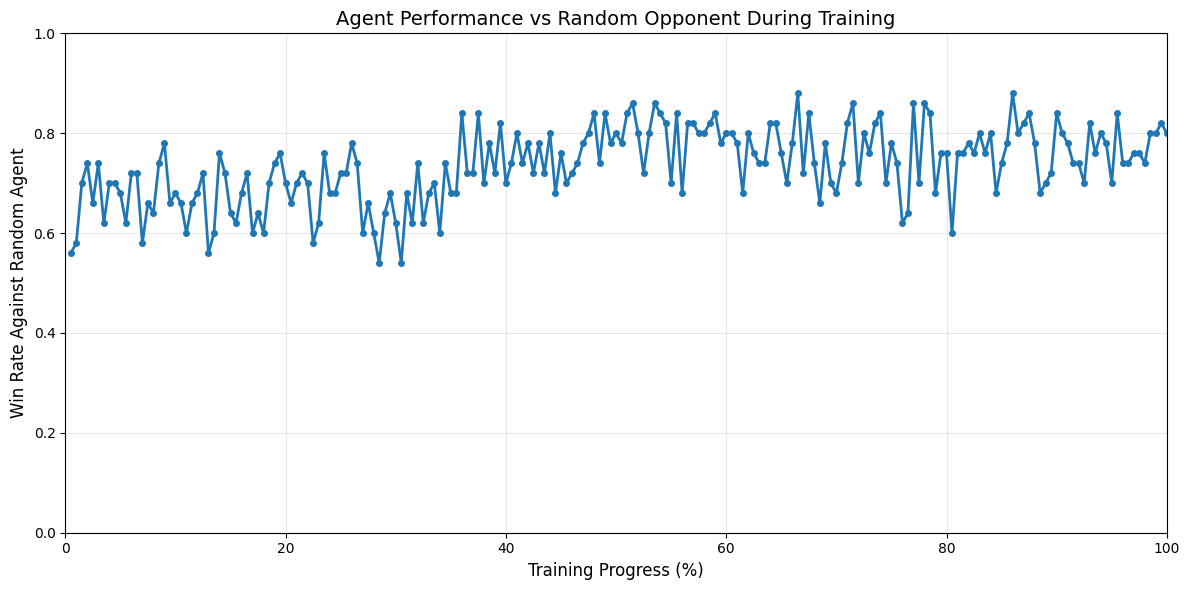

True winrate against random agent: 0.757

Training complete!


In [ ]:
# TRAINING CODE, DO NOT RUN UNLESS CREATING NEW MODEL

n_episodes = [1000, 10000, 100000]
titles = ["reinforce_agent_short", "reinforce_agent_medium", "reinforce_agent_long"]
update_freq = [100, 250, 500]

env = gym.make("gymnasium_env/mancala_env-v0")

for i in range(3):
    # Can adjust training hyperparameters of agent as needed
    reinforce_agent = ReinforceAgent(env, learning_rate=.001)
    # Train the agent
    reinforce_agent, env = reinforce_self_play(reinforce_agent, env, n_episodes=n_episodes[i], print_every=update_freq[i], agent_pool_size=10, use_current_ratio=0.5, update_every=update_freq[i])
    print(f"True winrate against random agent: {play_random(reinforce_agent, env, n_episodes=1000)}")
    torch.save(reinforce_agent.network.state_dict(), titles[i] + '.pth')
print(f"\nTraining complete!")